In [86]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os

In [87]:
def action_greedy(row):
    x, y, a, r = row['agent_x'], row['agent_y'], row['action'], row['rew']
    if (r > 0) and (x,y) == (0,2):
        return "put"
    elif r == - 1:
        return "walk"
    elif r == 0:
        return "stay"
    else:
        return "take"




In [88]:
def action(row):
    x, y, a, r = row['agent_x'], row['agent_y'], row['action'], row['rew']
    if (r > 0) and (x,y,a) in ([(0,1,3),(0,3,1),(1,2,4)]):
        return "put"
    elif r == - 1:
        return "walk"
    elif r == 0:
        return "stay"
    else:
        return "take"



In [89]:
def read_cnn(var):
    obvs = pd.read_csv(f'./logs/movement/Variant{var}/agent_movement_v{var}.csv')
    val_reward = pd.read_csv(f'./logs/movement/Variant{var}/validation_reward_v{var}.csv').iloc[:,1]
    obvs.columns = ['step', 'action', 'rew', 'agent_load', 'agent_y', 'agent_x']
    obvs["action2"] = obvs.apply(action, axis = 1)
    return obvs, val_reward



In [90]:
def read_dqn(var):
    obv = pd.read_csv(f"logs/movement/Variant{var}/obv_list_dqn")
    act = pd.read_csv(f"logs/movement/Variant{var}/act_list_dqn").iloc[:, 1]
    step_rew = pd.read_csv(f"logs/movement/Variant{var}/step_reward_dqn").iloc[:, 1]
    val_reward = pd.read_csv(f"logs/movement/Variant{var}/rew_list_dqn").iloc[:, 1]
    val_reward.columns = ["dqn_reward"]
    dqn = pd.concat([obv, act, step_rew], axis=1)
    header = ["step",
              "item1_y", "item1_x", "d_item1_agent", "d_item1_target", "item1_net_reward", "item1_time",
              "item2_x", "item2_y", "d_item2_agent", "d_item2_target", "item2_net_reward", "item2_time",
              "item3_y", "item3_x", "d_item3_agent", "d_item3_target", "item3_net_reward", "item3_time",
              "target0", "target1", "d_agent_target", "agent_y", "agent_x", "agent_load", "action", "rew"]
    dqn.columns = header
    dqn['action2'] = dqn.apply(action, axis = 1)
    return dqn, val_reward

x,y = read_dqn(2)


In [91]:
def read_greedy(var):
    df = pd.read_csv(f"logs/movement/Variant{var}/obv_greedy")
    header = ["step", "agent_y", "agent_x", "agent_load", "rew", "action"]
    df.columns = header
    val_reward_gd = pd.read_csv(f"logs/movement/Variant{var}/reward_greedy").iloc[:, 1]
    val_reward_gd.columns = ["gd_reward"]
    df["action2"] = df.apply(action_greedy, axis = 1)
    return df, val_reward_gd


In [92]:
def loc_heat_map(df: pd.DataFrame):
    color_palette = 'BuPu'
    x = df.groupby(['agent_x', 'agent_y'])['step'].count().reset_index()
    x["corr"] = x.agent_x.astype(str) + ',' + x.agent_y.astype(str)
    plt.figure(figsize=(8, 6))
    table = x.pivot("agent_y", "agent_x", "step")
    ax = sns.heatmap(table, cmap = color_palette)
    plt.show()


In [101]:
def loc_heat_map(df: pd.DataFrame):
    x = df.groupby(['agent_x', 'agent_y'])['step'].count().reset_index()
    x["corr"] = x.agent_x.astype(str) + ',' + x.agent_y.astype(str)
    plt.figure(figsize=(5, 4))
    table = x.pivot("agent_y", "agent_x", "step")
    ax = sns.heatmap(table, cmap = "Blues")
    plt.xlabel('x')
    plt.ylabel("y")


In [102]:
def compute_mean_net_reward(obv_df:pd.DataFrame):
    df = obv_df.copy()
    df['acc'] = 0
    df['net_reward'] = 0
    total_size = len(df)
    chunk_size = 200
    result = pd.DataFrame()
    for start_row in range(0, total_size, chunk_size):
        end_row = start_row + chunk_size
        df_sub = df.iloc[start_row: end_row,:]
        df_sub.acc =  df_sub.rew.cumsum()
        temp = pd.DataFrame(df_sub[df_sub["action2"].isin(["take","put"])].acc.diff())
        temp.columns =['net_reward']
        x_ = pd.merge(df_sub, temp, how = "left", left_index = True, right_index = True)
        x_['net_reward'] = x_["net_reward_y"]
        x_ = x_.drop(columns = ["net_reward_y","net_reward_x"])
        result = pd.concat([result, x_])
    return result

In [103]:
def compute_cost(df):
    chunk_size = 200
    total_size = len(df)
    result = []
    for start_row in range(0, total_size, chunk_size):
        end_row = start_row + chunk_size
        df.iloc[start_row: end_row, 7] = df.iloc[start_row:end_row,].rew.cumsum()
        temp = df.iloc[start_row: end_row, :].copy()
        x = np.array(temp[(temp['action2'] == "put") | (temp['action2'] == "take")].acc.diff())
        result.append(x)
    flattened_list = [item for sublist in result for item in sublist]
    return np.nansum(flattened_list,), flattened_list

    # return result

In [104]:
def location_stats(df1: pd.DataFrame, df2: pd.DataFrame):
    x = df1.groupby(['agent_x', 'agent_y'])['step'].count().reset_index()
    x["corr"] = x.agent_x.astype(str) + ',' + x.agent_y.astype(str)
    y = df2.groupby(['agent_x', 'agent_y'])['step'].count().reset_index()
    y["corr"] = y.agent_x.astype(str) + ',' + y.agent_y.astype(str)
    sum_x = pd.merge(x, y, on="corr")[["agent_x_x", "agent_y_x", "step_x", "step_y"]].groupby("agent_x_x")[
        ["step_x", "step_y"]].transform("sum")
    sum_y = pd.merge(x, y, on="corr")[["agent_x_x", "agent_y_x", "step_x", "step_y"]].groupby("agent_y_x")[
        ["step_x", "step_y"]].transform("sum")
    t = pd.concat([pd.merge(x, y, on="corr")[["agent_x_x", "agent_y_x", "step_x", "step_y"]], sum_x, sum_y], axis=1)

    t.columns = ["agent_x", "agent_y", "dqn_count", "gd_count", "dqn_x_count", "gd_x_count", "dqn_y_count", "gd_y_count"]
    t['diff_x'] = t['dqn_x_count'] - t['gd_x_count']
    t['diff_y'] = t['dqn_y_count'] - t['gd_y_count']
    stats_x = t[['agent_x', 'dqn_x_count', 'gd_x_count', 'diff_x']].drop_duplicates()
    stats_y = t[['agent_y', 'dqn_y_count', 'gd_y_count', 'diff_y']].drop_duplicates()
    return stats_x, stats_y


# Policy Analysis

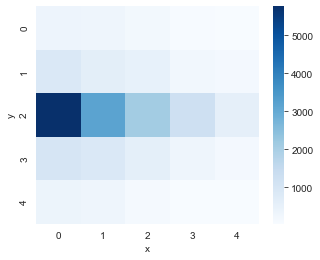

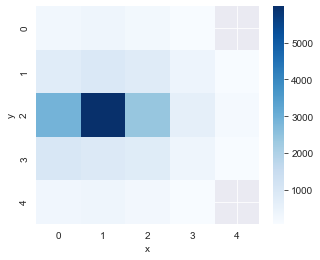

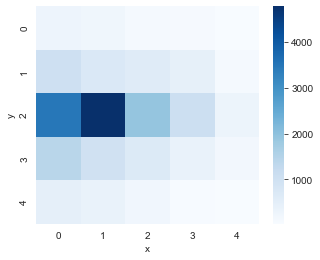

In [105]:
var = 0
g, gr = read_greedy(var)
c, cr = read_cnn(var)
q, qr = read_dqn(var)
rew_list = pd.concat([gr,cr,qr], axis = 1)
rew_list.columns = ['greedy','cnn','dqn']
obv_list = [g,c,q]

# Loop through the list of DataFrames and plot each DataFrame side by side
for i, df in enumerate(obv_list):
    loc_heat_map(df)


          greedy        cnn         dqn
count  100.00000  100.00000  100.000000
mean   218.85000  224.23500  221.390000
std     34.16881   34.06711   34.335803
min    145.00000  149.00000  157.000000
25%    194.75000  200.75000  196.000000
50%    215.75000  218.00000  215.500000
75%    238.75000  245.62500  239.625000
max    298.00000  310.00000  294.500000


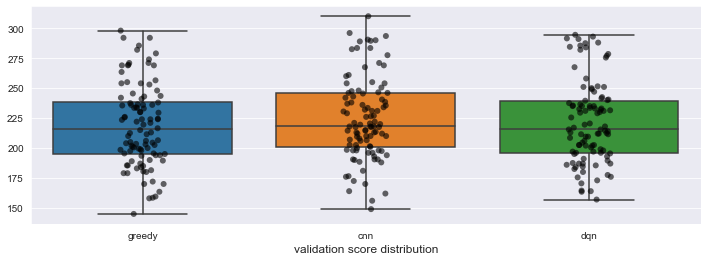

2    5723
4    5636
0    3230
3    2711
1    2700
Name: action, dtype: int64
rew   action2
-1.0  walk       11661
 0.0  stay        3185
 6.5  put         2558
      take        2551
 7.5  take          45
dtype: int64
2    5638
4    5571
0    3455
3    2674
1    2662
Name: action, dtype: int64
rew   action2
-1.0  walk       11328
 0.0  stay        3487
 6.5  put         2573
      take        2563
 7.5  take          49
dtype: int64
2    5879
4    5774
0    2814
3    2781
1    2752
Name: action, dtype: int64
rew   action2
-1.0  walk       11985
 0.0  stay        2773
 6.5  put         2597
      take        2594
 7.5  take          51
dtype: int64


/Users/meng/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


mean_nr: [action2
put     4.350665
stay         NaN
take    4.191506
walk         NaN
Name: net_reward, dtype: float64, action2
put     4.392344
stay         NaN
take    4.292994
walk         NaN
Name: net_reward, dtype: float64, action2
put     4.343281
stay         NaN
take    4.171513
walk         NaN
Name: net_reward, dtype: float64], take_unit:[]
           greedy         cnn         dqn
count  100.000000  100.000000  100.000000
mean   388.895000  405.460000  402.945000
std     47.716137   49.464184   49.015298
min    264.000000  282.000000  262.000000
25%    356.375000  373.375000  371.000000
50%    390.000000  402.000000  398.500000
75%    421.125000  437.875000  442.500000
max    496.000000  508.000000  510.500000


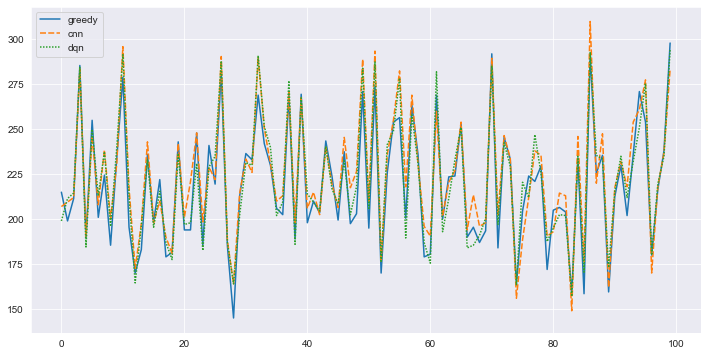

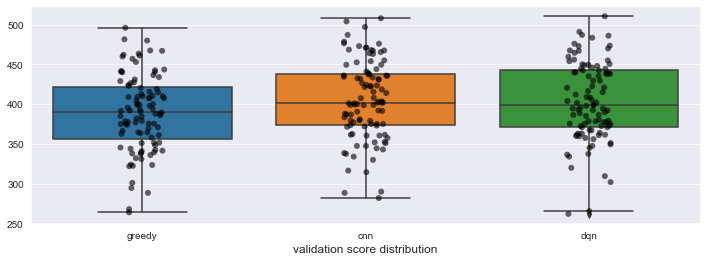

0    5227
2    4559
4    4378
1    2921
3    2915
Name: action, dtype: int64
rew    action2
-1.0   walk       10055
 0.0   stay        5105
 6.5   take        3526
 21.5  put         1143
 7.5   take         122
 14.0  put           29
 6.5   put           20
dtype: int64
2    5250
4    4691
0    3797
1    3140
3    3122
Name: action, dtype: int64
rew    action2
-1.0   walk       10379
 0.0   stay        4238
 6.5   take        3739
 21.5  put          851
 14.0  put          413
 6.5   put          307
 7.5   take          73
dtype: int64
2    4682
4    4562
0    4468
1    3152
3    3136
Name: action, dtype: int64
rew    action2
-1.0   walk       10319
 0.0   stay        4441
 6.5   take        3707
 21.5  put          958
 14.0  put          281
 6.5   put          218
 7.5   take          76
dtype: int64


/Users/meng/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


mean_nr: [action2
put     18.198406
stay          NaN
take     4.768884
walk          NaN
Name: net_reward, dtype: float64, action2
put     14.409930
stay          NaN
take     4.742188
walk          NaN
Name: net_reward, dtype: float64, action2
put     15.521620
stay          NaN
take     4.733234
walk          NaN
Name: net_reward, dtype: float64], take_unit:[]
           greedy         cnn         dqn
count  100.000000  100.000000  100.000000
mean   252.535000  252.970000  251.200000
std     56.043105   59.533957   59.170956
min    118.500000  133.000000  131.000000
25%    220.500000  217.000000  212.125000
50%    251.500000  249.500000  245.000000
75%    287.250000  286.875000  284.500000
max    399.000000  415.500000  407.500000


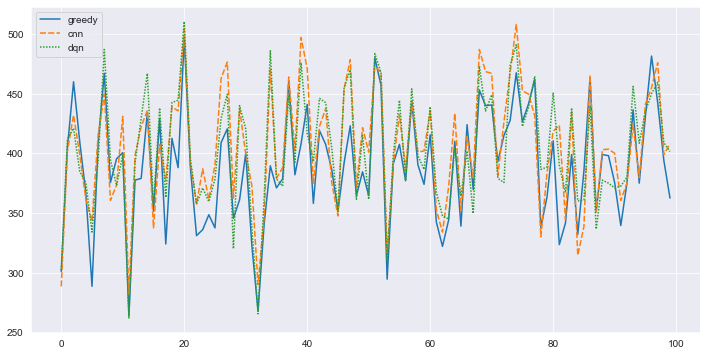

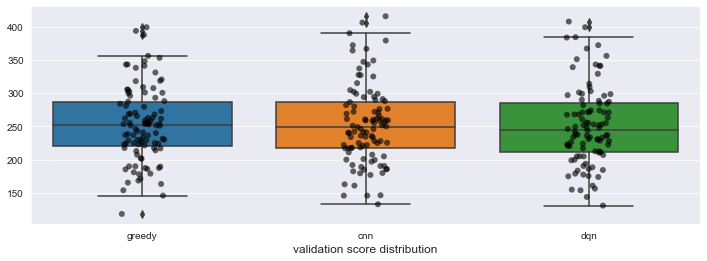

3    4596
1    4571
0    3991
2    3475
4    3367
Name: action, dtype: int64
rew    action2
-1.0   walk       12748
 0.0   stay        3951
 11.5  put         1631
       take        1630
 12.5  take          40
dtype: int64
2    6904
4    3813
1    3342
3    3317
0    2624
Name: action, dtype: int64
rew    action2
-1.0   walk       8641
 0.0   stay       8411
 11.5  put        1460
       take       1452
 12.5  take         36
dtype: int64
2    7450
4    3750
3    3376
1    3372
0    2052
Name: action, dtype: int64
rew    action2
-1.0   walk       8907
 0.0   stay       8137
 11.5  put        1464
       take       1459
 12.5  take         33
dtype: int64


/Users/meng/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


mean_nr: [action2
put     7.998467
stay         NaN
take    7.470701
walk         NaN
Name: net_reward, dtype: float64, action2
put     8.676027
stay         NaN
take    8.541787
walk         NaN
Name: net_reward, dtype: float64, action2
put     8.655738
stay         NaN
take    8.425287
walk         NaN
Name: net_reward, dtype: float64], take_unit:[]


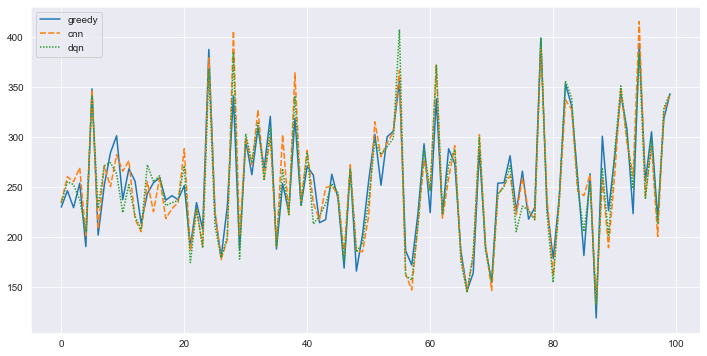

In [106]:
for j in range(3):
    var = j
    g, gr = read_greedy(var)
    c, cr = read_cnn(var)
    q, qr = read_dqn(var)
    rew_list = pd.concat([gr,cr,qr], axis = 1)
    rew_list.columns = ['greedy','cnn','dqn']
    obv_list = [g,c,q]


    ## Statistics
    print(rew_list.describe())

    ## plot jitter plot
    plt.figure(figsize=(12, 4))
    sns.boxplot(data=rew_list, width=0.8)  # Box plot
    sns.stripplot(data=rew_list, jitter=True, dodge=True, color='black', size=6, alpha=0.6)  # Dots
    plt.xlabel("validation score distribution",fontsize = 12)
    plt.show()


    ## plot heat map
    plt.figure(figsize =(12,6))
    sns.lineplot(data = rew_list)
    for o in obv_list:
        print(o.action.value_counts())
        # loc_heat_map(o)
        print(o[["rew","action2"]].value_counts())

    ## Compute efficiency
    mean_nr = []
    take_unit = []
    for i in obv_list:
        r = compute_mean_net_reward(i).groupby('action2')['net_reward'].mean()
        # take_unit.append(i.query('action2 == "take"')["step"].count())
        mean_nr.append(r)
    print(f"mean_nr: {mean_nr}, take_unit:{take_unit}")

    mean_nr, take_unit

<Axes: ylabel='Count'>

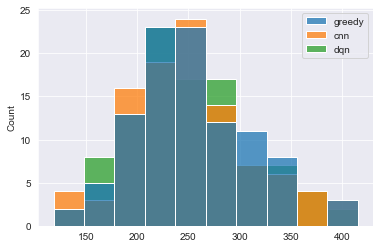

In [25]:
sns.histplot(data = rew_list, kde = False, multiple='dodge', bins = 10)

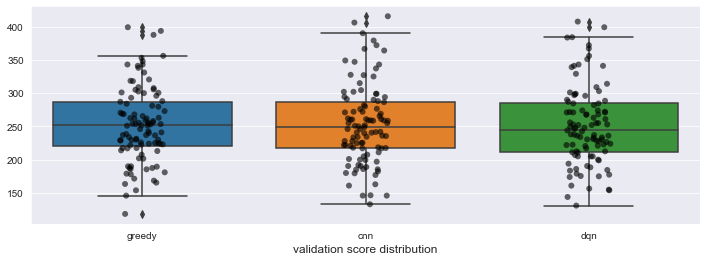

In [26]:

plt.figure(figsize=(12, 4))
sns.boxplot(data=rew_list, width=0.8)  # Box plot
sns.stripplot(data=rew_list, jitter=True, dodge=True, color='black', size=6, alpha=0.6)  # Dots
plt.xlabel("validation score distribution",fontsize = 12)
plt.show()


In [ ]:
sns.barplot(data = x, x = x.index, y = x.action)

In [ ]:
plt.figure(figsize = (12,6))
sns.histplot(data = x, x = "value", hue = "variable", multiple = "stack")